# 개발 시작

이전 며칠간의 확진자 수를 입력받아 다음 날의 확진자 수를 예측하는 방법.
3일 동안의 확진자 수 보고, 그 다음날 확진자 수가 어떻게 될지 학습함.
ex) 1, 2, 3 일 차 확진자 -> 4일차 확진자 예측.

연속된 데이터의 형태에서 그 패턴을 찾아냄. 순환 신경망 방식 (RNN).
(RNN = Recurrent Neural Network, 순환적 구조, 입출력을 시퀀스 단위로 처리.)


In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv

from keras.models import Sequential
케라스 모델 도구 중에서 시퀀셜 모델을 가져옴.

from keras.layers import SimpleRNN, Dense
레이어 도구 중에 심플RNN과 Dense 도구를 가져옴.
    - 순환 신경망 기법에는 LSTM, GRU 같은 다양한 기법이 있는데, SimpleRNN이 가장 기본적인 순환 신경망의 모습임.
    - Dense는 각 레이어에서의 뉴런의 수. 각 레이어에 들어가는 뉴런의 수를 정할 때 사용.


from sklearn.preprocessing import MinMaxScaler
데이터 정규화를 위한 MinMaxScaler 함수를 불러옴.
sklearn 라이브러리의 전처리 함수를 사용하는 거임.
데이터를 인공지능에서 사용하기 전에, 인공지능 모델에 적합하게 만드는 함수임.


from sklearn.metrics import mean_squared_error
mean_squared_error는 결과의 정확도를 계산하는 함수임.
이 인공지능은 연속된 값을 예측하는 회귀 문제임.
mean_squared_error는 실제 값과 예측 값의 차이를 사용하여 오류를 구함.

from sklearn.model_selection import train_test_split
데이터를 훈련데이터와 검증데이터로 나누는 함수임.
왜 나누냐? 인공지능의 성능을 측정할려고.

from pandas import read_csv
판다스는 파이썬에서 데이터 처리할 때 쓰는 라이브러리로, csv파일을 불러올 수 있는 명령어임.


# 데이터가져오기

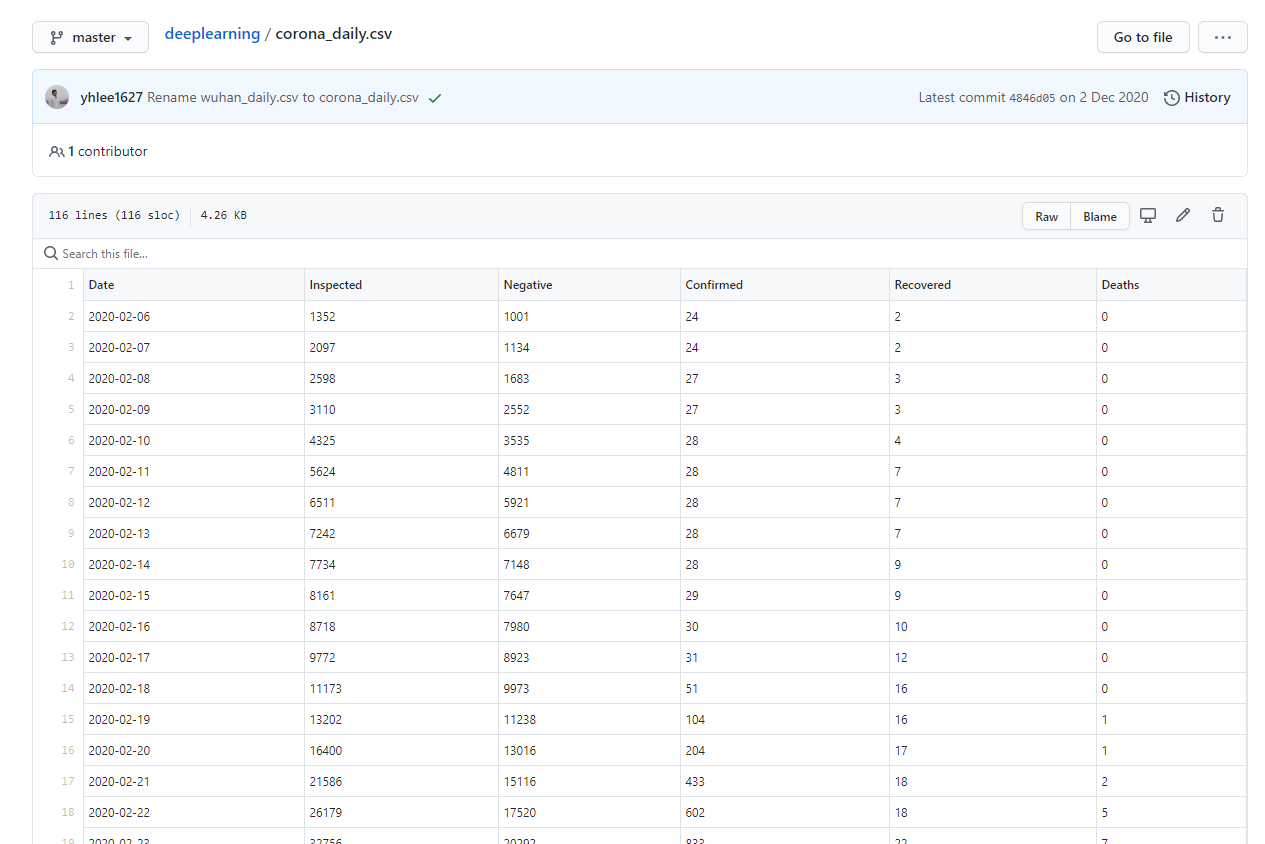

여기서 csv 파일을 가져올거임. (외부 데이터 사용)
https://github.com/yhlee1627/deeplearning.git 여기가 주소임.



In [ ]:
!git clone https://github.com/yhlee1627/deeplearning.git
dataframe = read_csv('/content/deeplearning/corona_daily.csv', usecols = [3], engine = 'python', skipfooter = 3)
print(dataframe)
dataset = dataframe.values
dataset = dataset.astype('float32')

!git clone 으로 깃허브 저장소를 가져옴.
그리고 그 안에 사용할 csv 파일의 주소를 가져와서 읽음.
4번째 열의 Confirmed(확진자) 데이터를 사용할거라 usecols 는 [3]을 하였고,
파이썬을 이용할 거니 엔진은 파이썬으로.
skipfooter은 뒤에서 3개의 행을 지운다? 생략하는 것이다.

읽어온 데이터에는 각 데이터에 대한 설명이나 순서같은 메타데이터가 포함되어있다.
따라서 필요한 값만 가져오기 위해 values로 필요한 값만 가져옴.
정규화할거니 float로 바꿔줌.



# 데이터 정규화 및 분류


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
Dataset = scaler.fit_transform(dataset)
train_data, test_data = train_test_split(Dataset, test_size = 0.2, shuffle = False)
print(len(train_data), len(test_data))

사이킷런 라이브러리에서 MinMaxScaler 함수를 사용해 정규화 방법을 설정함.
데이터의 정규화 범위를 0 ~ 1 로 설정함.

scaler를 사용하고 fit_transform 함수를 사용해 정규화를 실행함.

인공지능을 만들 때 인공지능의 성능을 정확하게 측정하기 위해 훈련 데이터와 검증 데이터를 사용함.
trans_test_split 함수는 전체 데이터를 훈련데이터와 검증데이터로 분류하는 함수임
첫번째 인자는 분류할 데이터를 넣고,
두번째 인자는 검증 데이터 비율을 설정하는 것이고, (훈련데이터 8 : 검증데이터 2)
세번째 인자는 추출방법임. 셔플이 True면 무작위 추출이고, 셔플이 False면 순차 추출임.
지금 만들려는 인공지능은 순서가 중요한 날짜별 데이터를 사용하니 순차 추출을 해야함.

훈련데이터와 검증데이터 개수를 출력해보니 8 : 2 가 얼추 맞음.


#데이터 형태 변경

1일차, 2일차, 3일차 연속된 데이터를 순환 신경망 모델에 넣으면 4일차를 예측하여 반환하는 식이니 이에 맞게 데이터의 형태를 변경해야함.

현재는 1일차, 2일차, 3일차, 4일차, ..., n일차 로 한 줄로 나열되어있음
순환신경망에서는 어떤 방식으로 데이터를 넣을지 정하는게 매우 중요함.

x_data  y_data
123   |    4
234   |    5
345   |    6
...
이런식의 데이터입력을 해야함.




In [ ]:
def create_dataset(dataset, look_back) :
    x_data = []
    y_data = []
    for i in range(len(dataset) - look_back) :
        data = dataset[i:(i+look_back), 0]
        x_data.append(data)
        y_data.append(dataset[i + look_back, 0])
    return numpy.array(x_data), numpy.array(y_data)

데이터형태를 바꾸는 함수를 만듬.
첫번째 인자는 원래의 데이터( 바꿀 데이터 ) , 두번째 인자는 데이터의 개수.

for 문을 보면, 만약 전체 데이터가 10개면 3일간 해서 다음날 예측이니 총 7번을  반복해야함. range(7).
같은 방법으로 저 횟수만큼 반복함.

data는 세개씩 묶고 다음 하나는 예측할 데이터 이니, 첫번째 열부터 세번째 열의 데이터를 추출함. [ 0:3 , 0 ] 행은 안바뀌니 0으로 고정. 
여기서 array [ x : y ] 는 x에서 y 이전의 값까지 인덱스 값을 출력 하는 것이다.

3개를 뽑은 data 변수의 값을 x_data 배열에 넣어주고,
y_data 배열에는 그 다음 값을 넣어줌.
 > x_data 에는 1일차, 2일차, 3일차.
 > y_data 에는 4일차.

이제 변환된 x_data 와 y_data 배열을 넘파이 배열로 변경시킴.


# 입력데이터 생성


앞에서 만든 함수를 사용해 실제 인공지능 모델에 입력할 데이터를 만듬.
AI 제작의 시작은 데이터를 잘 정리하는 것 부터 시작됌.
따라서 데이터를 인공지능 모델에 맞게 만드는 작업을 중요시하고 많은 생각을 해야함.

In [ ]:
look_back = 3
x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

입력데이터를 모델에 맞는 형태로 변환해야한다.
현재 데이터는 86 * 3 으로 2차원 배열로 되어있는데,
이를 각각의 줄로 나눠서 1 * 3의 형태로 입력을 하기위해 3차원 배열로 86 * 1 * 3 으로 변경해준다.


In [ ]:
X_Train = numpy.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_Test = numpy.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print(X_Train.shape)
print(X_Test.shape)

# 모델 제작




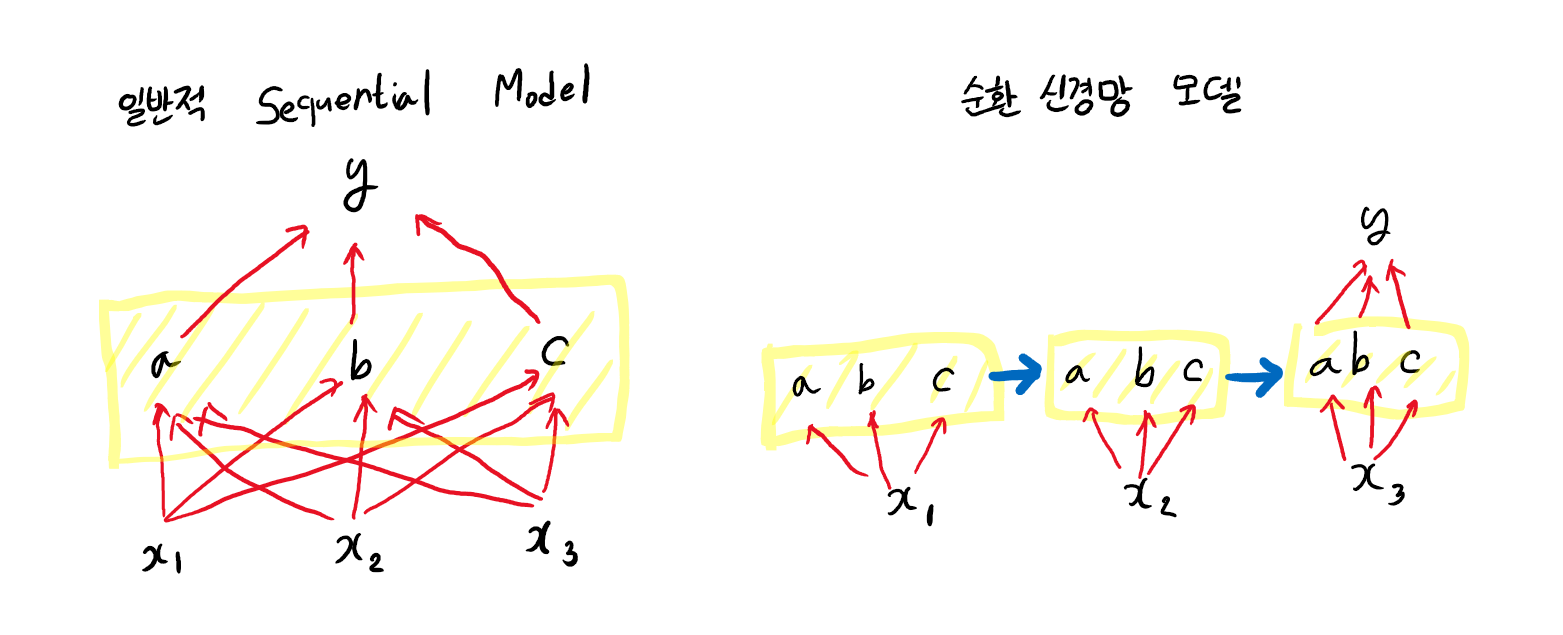

일반 시퀀셜 모델은 입력 데이터가 은닉층을 거쳐서 출력층까지 전달되어 특정한 값을 예측.
순환 신경망 모델은 모든 데이터를 한번에 넣는 것이 아닌, 순서대로 하나씩 넣음.
첫번째 데이터를 넣고 은닉층에 있는 파라미터( 가중치와 편향)의 값을 학습시킴.
그리고 결과로 나온 파라미터를 바로 다음 단계에서 사용하도록 넘김.
그러면 은닉층에 이전에 학습한 결과와 다음 데이터를 넣고 학습시키고 이런식으로  쭉 이어나감.


In [ ]:
model = Sequential()
model.add(SimpleRNN(3, input_shape=(1,look_back)))
model.add(Dense(1, activation="linear"))
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

모델은 시퀀셜 모델을 만듬.
순환신경망(RNN) 도 레이어들이 선형으로 연결된 형태니 시퀀셜 모델로 설정함.

그리고 이 시퀀셜 모델을 simpleRNN 을 사용하고, 뉴런의 수는 3, 입력받는 데이터의 형태를 설정함.
지금 3일치 데이터로 다음날 예측한다고 해서 1*3 형태로 입력받는다고 한건데 입력할 데이터는 함수로 만들어서 바꿀수 있음. 따라서 1,look_back으로 설정한거임.

확진자의 수만 따질 것이니 1개의 노드만으로 구성함.

compile 즉, 계산 방법은 mse(평균 제곱 오차, mean_squared_error)로 사용하고,
adam 옵티마이저를 사용함.
평균제곱오차를 이용하는 이유는 실제 확진자 수와 예측한 값의 차이를 비교하여 오차를 나타내기 때문.

summary 는 요약임.
지금까지 작성한 모델을 표시해주는 함수이다.

결과보면 
총 노드의 수 3개.
 Param은 파라미터(가중치와 편향 값)의 수.
  Dense는 출력층에서의 형태와 파라미터 수.

# 모델 학습


In [ ]:
model.fit(X_Train, y_train, epochs=100, batch_size = 1, verbose=1)

입력데이터, 출력데이터, 반복횟수, 한번에 학습시킬 데이터의 양, 진행상태 애포크별로 알려주게 설정해논다.



#데이터 예측 / 모델 성능 측정

모델을 학습하고 해야하는 것은 모델의 성능을 측정해봐야한다.
성능을 측정하려면 실제 데이터의 값과 예측한 데이터 값과의 차이를 비교해 보아야한다.
예측값과 실제값을 정규화 하기 이전의 값으로 비교해야한다.


In [ ]:
trainPredict = model.predict(X_Train)
testPredict = model.predict(X_Test)
TrainPredict = scaler.inverse_transform(trainPredict)
# print(trainPredict)
# print(" ------ ")
# print(TrainPredict)
Y_Train = scaler.inverse_transform([y_train])
TestPredict = scaler.inverse_transform(testPredict)
Y_Test = scaler.inverse_transform([y_test])

predict 함수는 모델에 데이터를 넣어서 결과값을 예측하는 함수.

scaler는 이전에 만든 함수임. 기존에 존재하는 함수가아닌 정규화를 하려고 sklearn 라이브러리의  MinMaxScaler로 만든거였음.
거기있는 inverse_transform은 0과 1 사이의 값으로 정규화된 값을 원래의 자연수 형태의 값으로 돌려주는 함수임.

실제 확진자 수, 내가 필요한 데이터의 값은 y_train과 y_test 변수 안에 있으니 []안에 넣어줌.



#모델 정확도 확인

필요한 값들을 정규화 이전의 값으로 돌렸으니 이제 모델이 예측한 값과 실제 값의 차이가 어느정도 나는지 확인해보아야한다.
평균 제곱근 오차 (Root Mean Squared Error).


In [ ]:
trainScore = math.sqrt(mean_squared_error(Y_Train[0], TrainPredict[:,0]))
print(trainScore)
testScore = math.sqrt(mean_squared_error(Y_Test[0], TestPredict[:,0]))
print(testScore)

첫번째 인자에는 실제 정답값 전체를 가져오고, 두번째 인자에는 예측값 전체를 가져옴.
[:,0] 인 이유는 배열이 2차원 배열로 이루어져 있기 때문.
mean_squared_error가 자동으로 오차의 값을 제곱해서 각각의 값을 더하고 그 결과를 반환함. 따라서 평균 제곱근 오차를 구하기 위해 sqrt로 제곱근값을 구함.


#결과그래프

실제 데이터와 예측한 훈련데이터, 검증데이터를 그래프로 표시해봤다.

In [ ]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[ : , : ] = numpy.nan
trainPredictPlot[look_back : len(TrainPredict)+look_back, :] = TrainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[ : , : ] = numpy.nan
testPredictPlot[len(TrainPredict) + ((look_back + 1) * 2) -2 : len(dataset), : ] = TestPredict

plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title("Covid19")
plt.show

실제 데이터와 예측한 데이터를 비교하기위해 전체 데이터(dataset)와 같은 형태의 배열을 생성함. 여기서 numpy 라이브러리의 empty_like 는 인자값과 같은 형태의 배열을 만들어주는 함수이다.
그리고 nan함수를 이용해 배열안에 있는 전체의 값을 nan으로 초기화 시켜준다.
깨끗한 배열에 처음 3일치를 바탕으로 4일차 부터 예측을 하기에 건너띄고 처음값은 lool_back부터 훈련 데이터를 예측한 결과값 구간을 정해준다.

그다음은 검증데이터를 똑같은 방법으로 그려준다.

plt 라이브러리의 plot함수를 사용하여 값들을 그래프로 그린다.

처음 0,0부터 시작하는 선이 실제 확진자 수이고,
나머지 선은 예측한 확진자 수이다.
비슷하게 예측하는 것 같다.

#후기


모델을 제작하는 비중이 생각보다 크지 않았다.
대부분의 시간을 데이터를 건드리는 것에 투자한 것같다.
데이터를 인공지능 모델에 넣을 수 있게 변환을 하고, 보기 쉽게 또 변환을 하고, 데이터의 형태를 계속해서 바꿀 수 있는 능력이 필요하다 느꼈다.
또한, 다른 여러가지 데이터를 가지고 다른 AI모델을 제작해봐야겠다는 생각을 하였다.
현재 인공지능이 어떤식으로 제작이 되고 어떤 순서로 써야하는지 어느정도 이해가 되는 것 같지만, 아직 멀은 것 같다.
케라스와 사이킷런, 텐서플로우의 라이브러리에 익숙해져야 될 것 같다.
